In [2]:
import numpy as np
import matplotlib
from matplotlib import colors
import matplotlib.pyplot as plt
import geone
import geone.covModel as gcm
import geone.imgplot3d as imgplt3
import geone.geosclassicinterface as gci
import pyvista as pv
import sys
import scipy

import os

import shapely
from shapely.geometry import Polygon, LineString, MultiPolygon, MultiLineString
import rasterio
import rasterio.features
from rasterio import Affine

import EROS

%load_ext autoreload
%autoreload 2

In [3]:
def apply_facies(arr, dic_res):
    
    res = arr.copy()
    for k,v in dic_res.items():
        res[arr==k]=v
    return res

def plot_bh(w_logs, width=1):
    
    for s in w_logs:
        
        x,y, log = s
        z_0 = log[0][1] - y
        for unit in log:
            np.random.seed(unit[0]+24)
            plt.bar(x, unit[1] - z_0, bottom=z_0, linewidth=width, edgecolor="black", color=np.random.random(size=3), width=width)


In [4]:
ox = 0
nx = 100
sx = 1.5
xg = np.arange(ox, ox+sx*(nx+1), sx)
xgc = np.linspace(ox+sx/2, ox+sx*nx-sx/2, nx)
plot_xg = np.linspace(ox, ox+nx*sx, nx)
nz = 300
sz = 1/6
oz = 0
z1 = oz+nz*sz
x1 = ox + nx*sx

# parameters
var = 10
r = 50

cm = gcm.CovModel1D(elem=[("cubic", {"w":var, "r":r})])
# sim = geone.geosclassicinterface.simulate1D(cm,nx,sx, nreal=N_surf)["image"].val[:, 0, 0, :]

In [5]:
w_logs = [(13.636363636363637, 30, [(1, 50), (2, 40), (3, 33), (1, 30)]),
 (65.15151515151516, 20, [(2, 50), (1, 42), (3, 36)]),
 (125.75757575757575, 23, [(2, 50), (1, 43), (3, 32)]),
 (100, 15, [(2, 50), (1, 46)]),
 (40, 15, [(4, 20), (3, 10)])]

(0.0, 50.0)

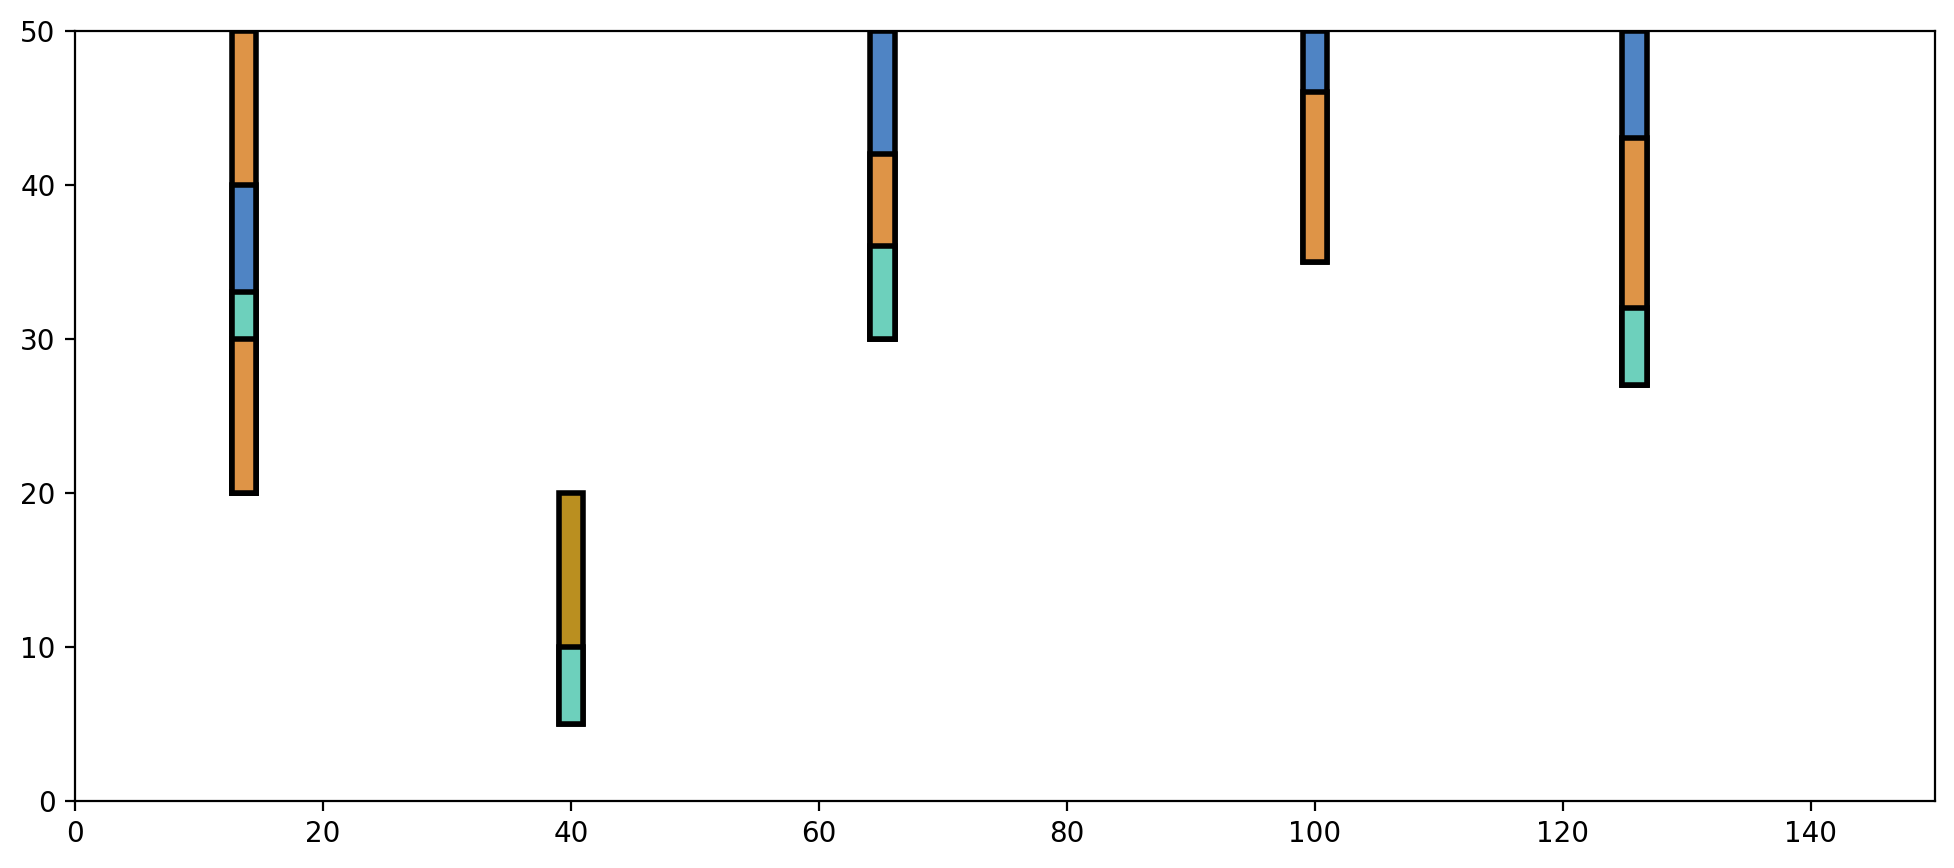

In [6]:
fig, axs = plt.subplots(figsize=(12,5), dpi=200)
plot_bh(w_logs, 2)
plt.xlim(0, 150)
plt.ylim(0, 50)

In [7]:
import EROS

In [8]:
N = 100
means = np.random.uniform(-5, 55, size=N)

In [9]:
means = np.sort(means)

In [18]:
%%time
real_surf, arr_res, list_p_cond = EROS.sim_cond_2D(100, cm, means,
                                      (nx, nz), (sx, sz), (ox, oz), w_logs, alpha=0, xi=0.1, seed=5)

CPU times: total: 7.16 s
Wall time: 658 ms


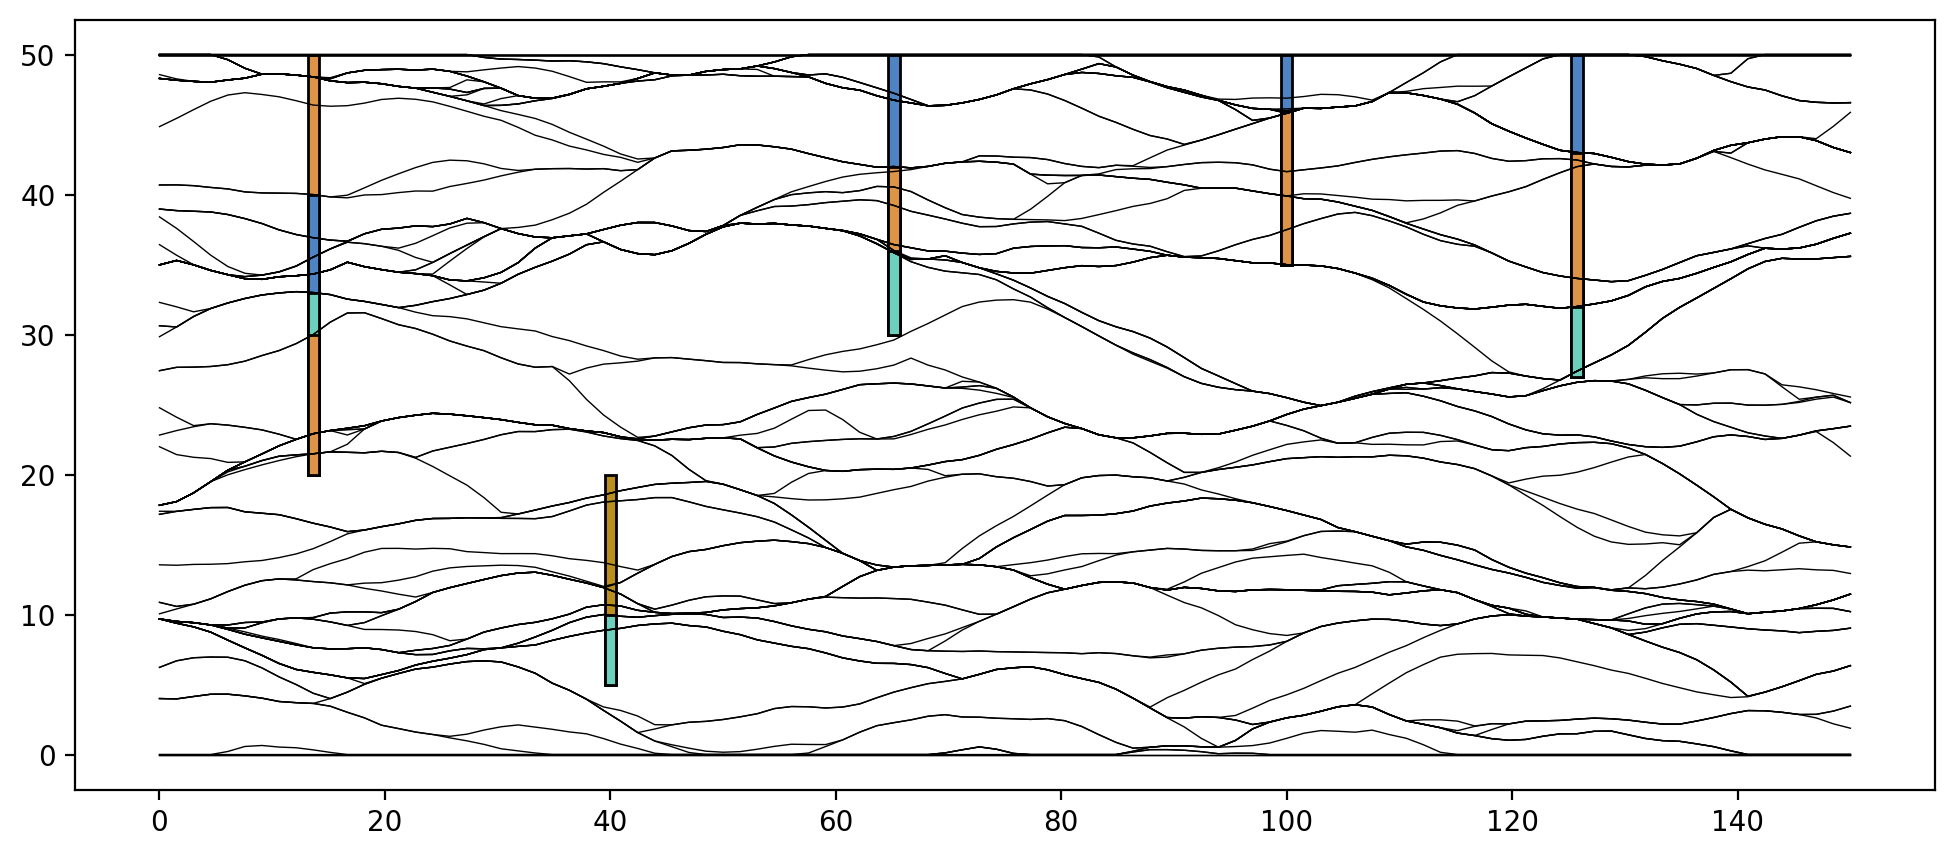

In [19]:
fig, axs = plt.subplots(figsize=(12,5), dpi=200)
plt.plot(plot_xg, real_surf.T, c="k", linewidth=.5)
plot_bh(w_logs)
plt.show()

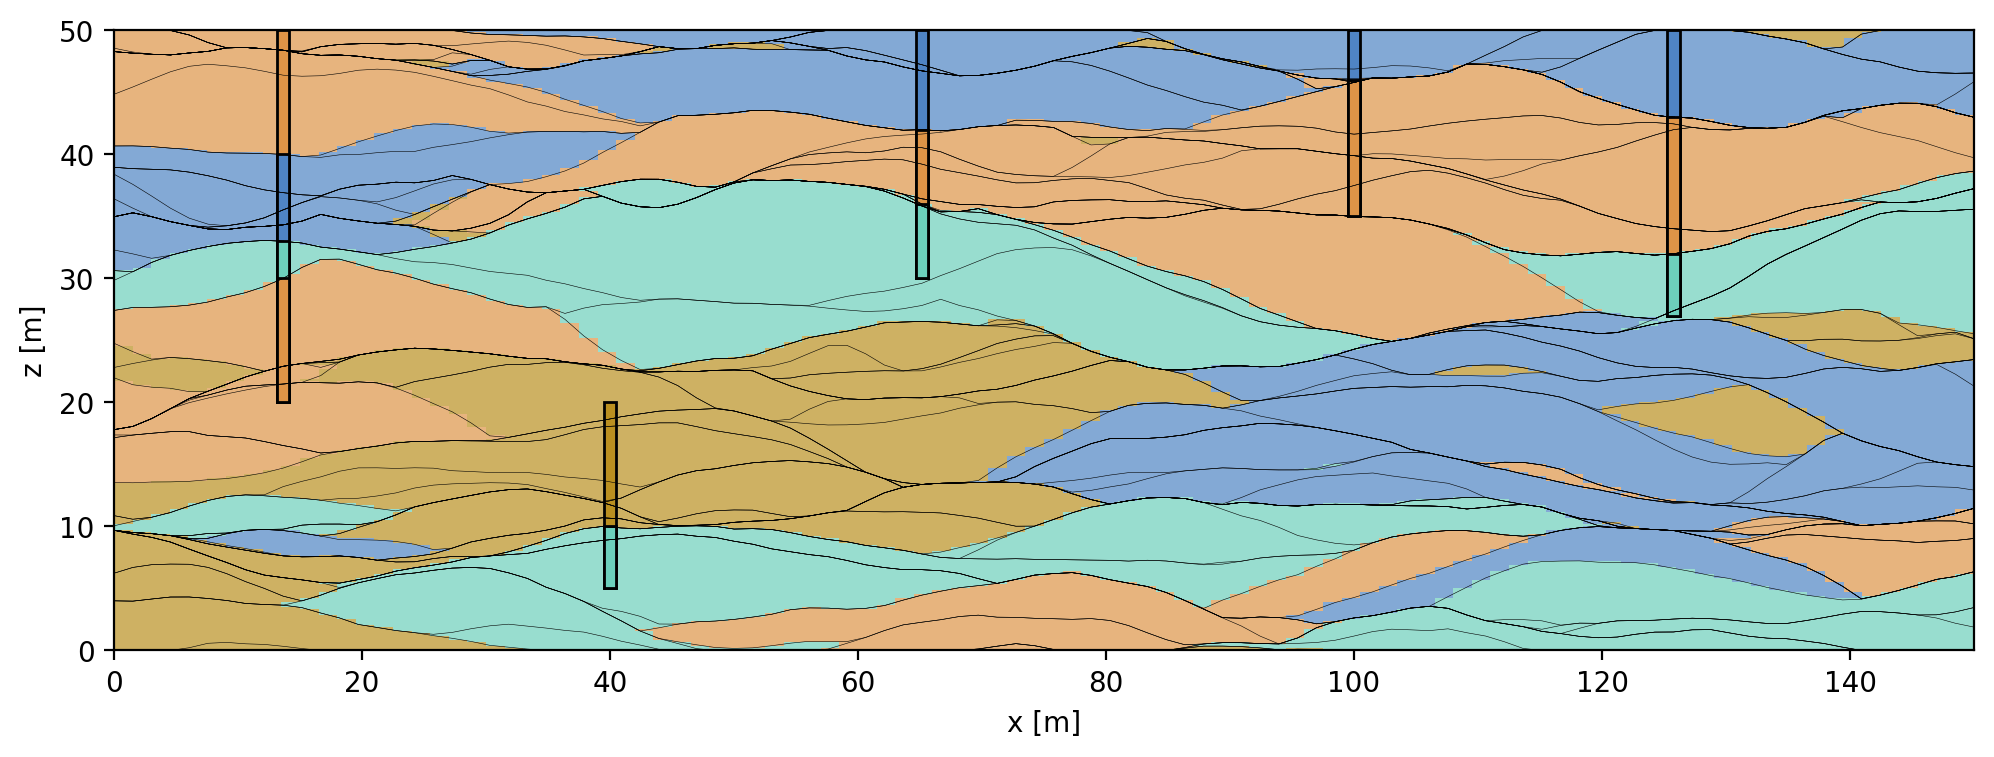

In [20]:
arr_plot = np.zeros([nz, nx, 3])
for ival in np.unique(arr_res):
    np.random.seed(ival+24)
    arr_plot[arr_res==ival] = np.random.random(size=3)
    
fig, axs = plt.subplots(figsize=(12,5), dpi=200)
plt.imshow(arr_plot, extent=[ox, x1, oz, z1], origin="lower", interpolation="none", alpha=.7)
plt.plot(plot_xg, real_surf.T, c="k", linewidth=.2)
plt.xlabel("x [m]")
plt.ylabel("z [m]")
plot_bh(w_logs)
plt.show()

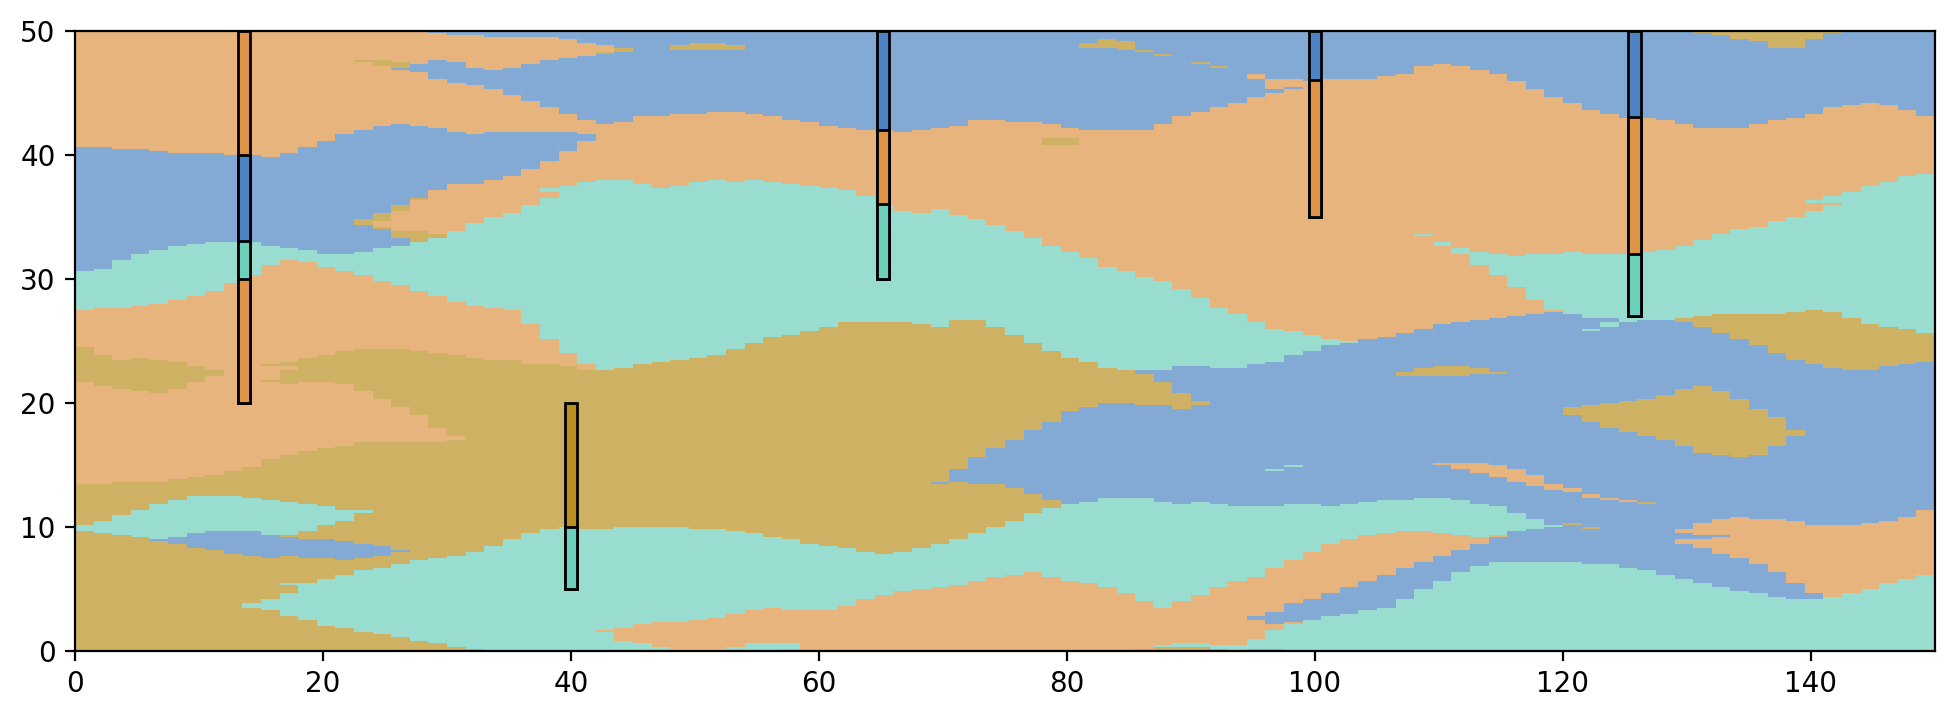

In [21]:
arr_plot = np.zeros([nz, nx, 3])
for ival in np.unique(arr_res):
    np.random.seed(ival+24)
    arr_plot[arr_res==ival] = np.random.random(size=3)
    
fig, axs = plt.subplots(figsize=(12,5), dpi=200)
plt.imshow(arr_plot, extent=[ox, x1, oz, z1], origin="lower", interpolation="none", alpha=.7)
plot_bh(w_logs)
plt.show()

In [22]:
real_surf, arr_res, list_p_uncond = EROS.sim_uncond_2D(100, cm, means,
                                      (nx, nz), (sx, sz), (ox, oz), alpha=0, xi=0.1, seed=20)

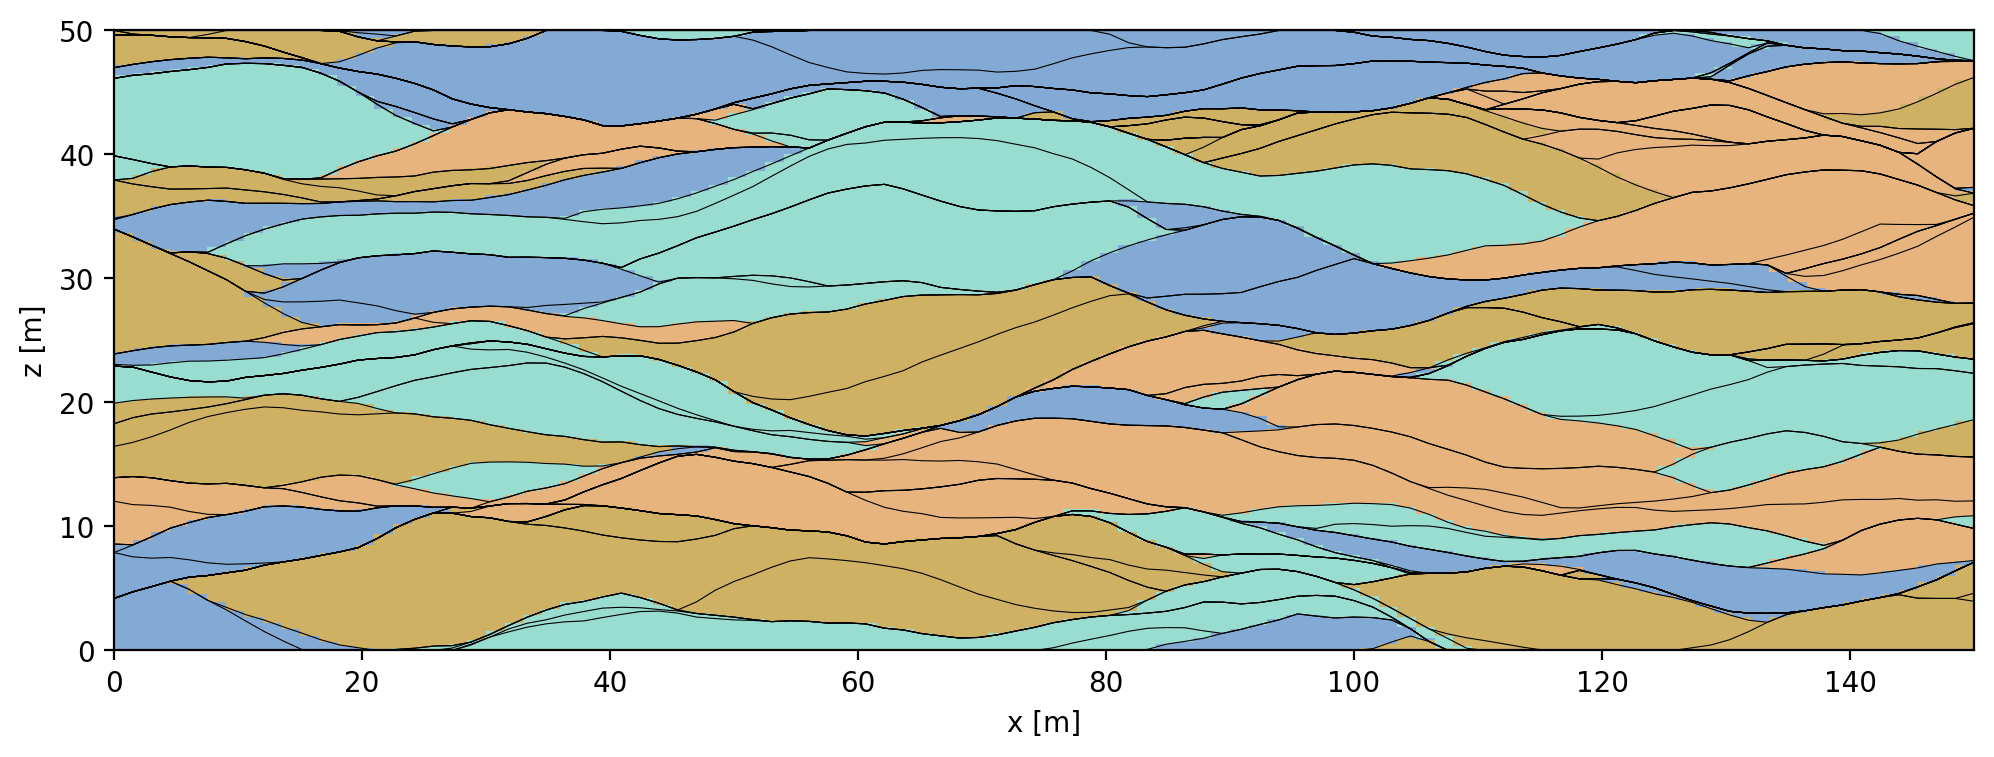

In [23]:
arr_plot = np.zeros([nz, nx, 3])
for ival in np.unique(arr_res):
    np.random.seed(ival+24)
    arr_plot[arr_res==ival] = np.random.random(size=3)
    
fig, axs = plt.subplots(figsize=(12,5), dpi=200)
plt.imshow(arr_plot, extent=[ox, x1, oz, z1], origin="lower", interpolation="none", alpha=.7)
plt.plot(plot_xg, real_surf.T, c="k", linewidth=.4)
plt.xlabel("x [m]")
plt.ylabel("z [m]")
plt.show()

In [24]:
from itertools import chain

In [26]:
n = 20

leng_un = []
leng_cd = []
wid_un = []
wid_cd = []
area_un = []
area_cd = []
for i in range(n):
    
    real_surf, arr_res, list_p_uncond = EROS.sim_uncond_2D(100, cm, means,
                                          (nx, nz), (sx, sz), (ox, oz), alpha=0, xi=0.1, seed=np.random.randint(1e5))
    
    real_surf, arr_res, list_p_cond = EROS.sim_cond_2D(100, cm, means,
                                          (nx, nz), (sx, sz), (ox, oz), w_logs, alpha=1, xi=0.1, seed=np.random.randint(1e5))
    
    # length
    dx = [p.bounds[2] - p.bounds[0] for p in list_p_uncond]
    leng_un.append(dx)
    dx = [p.bounds[2] - p.bounds[0] for p in list_p_cond]
    leng_cd.append(dx)
    
    # width
    dy = [p.bounds[3] - p.bounds[1] for p in list_p_uncond]
    wid_un.append(dy)
    dy = [p.bounds[3] - p.bounds[1] for p in list_p_cond]
    wid_cd.append(dy)
    
    # area
    area_cd.append([i.area for i in list_p_cond])
    area_un.append([i.area for i in list_p_uncond])
    
leng_cd = list(chain.from_iterable(leng_cd))
leng_un = list(chain.from_iterable(leng_un))
wid_cd = list(chain.from_iterable(wid_cd))
wid_un = list(chain.from_iterable(wid_un)) 
area_cd = list(chain.from_iterable(area_cd))
area_un = list(chain.from_iterable(area_un)) 

61 gne
78 gne
91 gne
67 gne
94 gne


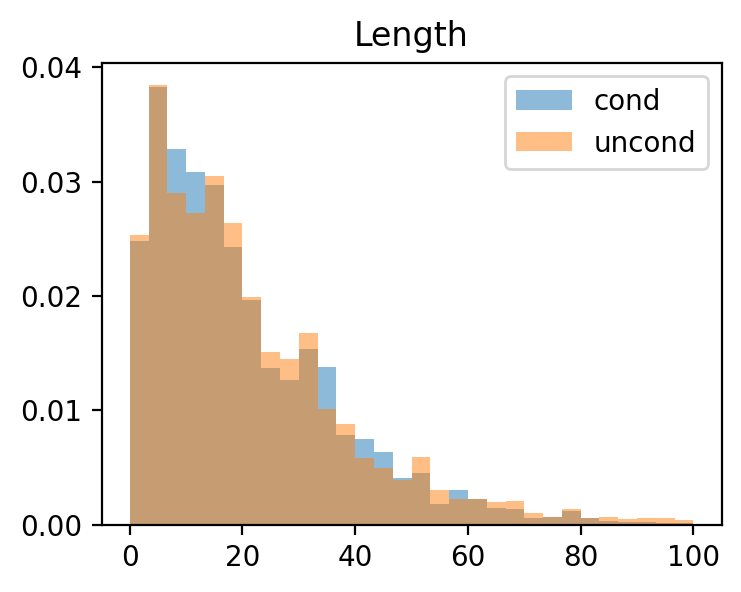

In [27]:
plt.figure(figsize=(4, 3), dpi=200)
plt.hist(leng_cd, bins=30, alpha=0.5, label="cond", density=True, range=(0, 100))
plt.hist(leng_un, bins=30, alpha=0.5, label="uncond", density=True, range=(0, 100))
plt.title("Length")
plt.legend()

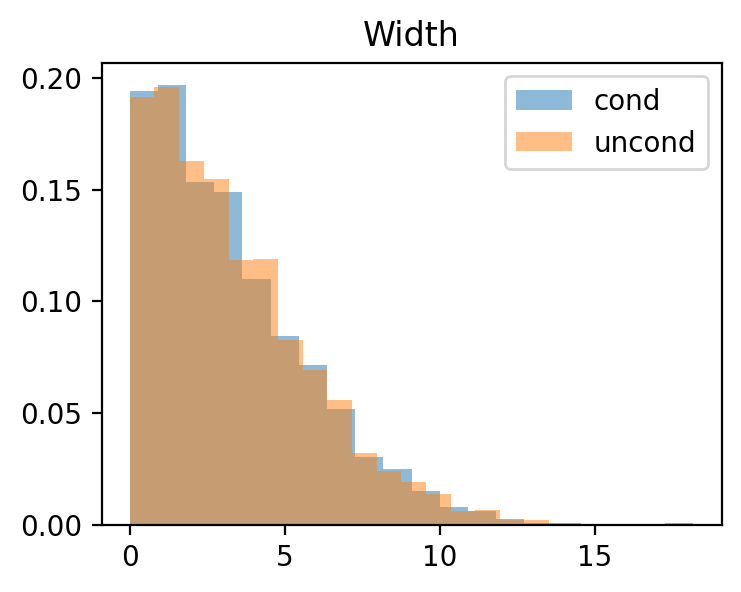

In [28]:
plt.figure(figsize=(4, 3), dpi=200)
plt.hist(wid_cd, bins=20, alpha=0.5, density=True, label="cond")
plt.hist(wid_un, bins=20, alpha=0.5, density=True, label="uncond")
plt.title("Width")
plt.legend()

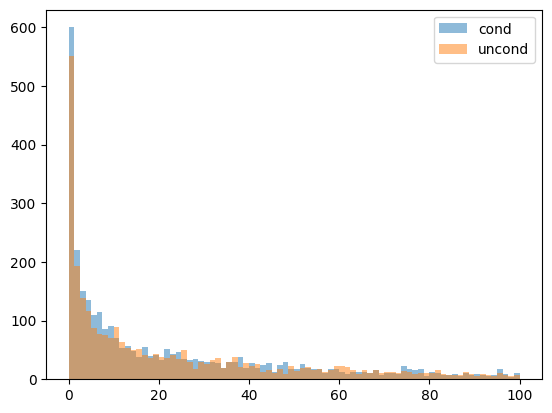

In [29]:
plt.hist(area_cd, 80, range=(0, 100), alpha=0.5, label="cond")
plt.hist(area_un, 80, range=(0, 100), alpha=0.5, label="uncond")
plt.legend()